# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Student 1 - __[Ghita.Ait.Ouhmane@ulb.ac.be](mailto:Ghita.Ait.Ouhmane@ulb.ac.be) - Student ID 453422__
### Student 2 - __[Ha.Duong@ulb.ac.be](mailto:Ha.Duong@ulb.ac.be) - Student ID 463350__
### Student 3 - __[Maxime.Langlet@ulb.ac.be](mailto:Maxime.Langlet@ulb.ac.be) - Student ID 427821__

### Video presentation: www.youtube.com/abcd1234

## Statistical foundations of Machine Learning - Project 2020-2021


# Introduction


The goal of this project is to participate in a competition on the DrivenData Website. The competition is called "Pump it Up: Data Mining the Water Table".<br>
It is a multi label classification problem and the objective is to first preprocess the dataset by doing some feature selection, and follow it by implementing different type of models and evaluate each one of them to asses their perfromances. Finally the predictions must be submitted on the website to enter the competition.<br>
Each step will be explained in more details in the following sections.

 We first load all the necessary packages and libraries into the notebook : 


In [1]:
# install the packages and libraries
# install.packages("e1071")
# install.packages("tidyverse")
# install.packages("pillar")
# install.packages("caret")

# install.packages("xgboost")

#if problem with install of xgboost, try the following
# install.packages("drat", repos="https://cran.rstudio.com")
# drat:::addRepo("dmlc")
# install.packages("xgboost", repos="http://dmlc.ml/drat/", type = "source")

# install.packages("archdata")
# install.packages("caret") # for the confusionmatrix() function (also needs e1071 package)
# install.packages("dplyr") # for some data preperation
# install.packages("Ckmeans.1d.dp") # for xgb.ggplot.importance


library(rpart)
library(e1071)
library(rpart.plot)
library(randomForest)
library(nnet)
library(FactoMineR)
library(factoextra)
library("xgboost") # the main algorithm
library("archdata") # for the sample dataset
library("caret") # for the confusionmatrix() function (also needs e1071 package)
library("dplyr") # for some data preperation
library("Ckmeans.1d.dp") # for xgb.ggplot.importance

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: lattice


Attaching package: ‘dplyr’


The following object is masked from ‘package:xgboost’:

    slice


The following object is masked from ‘package:randomForest’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




We then read the data given in csv format : <br>
- Training_set_values.csv :  it consists of the training data, containing all the features values to use in the training.
- Training_set_labels.csv : These are the labels of the training set, which means the prediction expected for each row of the dataset.
- Test_set_values.csv : Those are the data that will be used to asses the accuracy of our models. 
- Submission_format.csv : This is the format under which we have to submit our prediction on the test set described previously fo the dataDriven competition.

In [2]:
# read the datasets

sub_format <- read.csv("database/Pump_it_Up_Data_Mining_the_Water_Table_-_Submission_format.csv", header=TRUE)
set_val_test <- read.csv("database/Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv", header=TRUE)
set_labels <- read.csv("database/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv", header=TRUE)
dataset <- read.csv("database/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv", header=TRUE)

# print the number of values of the Y
table(set_labels$status_group)


             functional functional needs repair          non functional 
                  32259                    4317                   22824 

We see that there can be three possible values for the predicition :<br>
- functional - the waterpoint is operational and there are no repairs needed
- functional needs repair - the waterpoint is operational, but needs repairs
- non functional - the waterpoint is not operational
Another thing we can notice right away, is that the dataset in imbalanced : the total number of entries in the dataset is 59400 , and the functional_needs_repair label is only predicted 4317 times, so around 7% of the time. This can already introduce some bias on the model, making him perform less when tested.

# Data preprocessing
Now that we have laoded our data, we can start the preprocessing

## Feature selection

In [3]:
dim(dataset)
sapply(dataset, class)

[1] 59400    40

id            amount_tsh         date_recorded 
            "integer"             "numeric"           "character" 
               funder            gps_height             installer 
          "character"             "integer"           "character" 
            longitude              latitude              wpt_name 
            "numeric"             "numeric"           "character" 
          num_private                 basin            subvillage 
            "integer"           "character"           "character" 
               region           region_code         district_code 
          "character"             "integer"             "integer" 
                  lga                  ward            population 
          "character"           "character"             "integer" 
       public_meeting           recorded_by     scheme_management 
          "character"           "character"           "character" 
          scheme_name                permit     construction_year 
          "character"           "character"             "integer" 
      extraction_type extraction_type_group extraction_type_class 
          "character"           "character"           "character" 
           management      management_group               payment 
          "character"           "character"           "character" 
         payment_type         water_quality         quality_group 
          "character"           "character"           "character" 
             quantity        quantity_group                source 
          "character"           "character"           "character" 
          source_type          source_class       waterpoint_type 
          "character"           "character"           "character" 
waterpoint_type_group 
          "character"

We now have to see which features will be kept, and which one introduce redundancy, or whose information aren't relevant to the problem.<br>
We can see that there are 40 columns in our dataset.<br>
Looking at the column types, we come accross two types of values : numerical and categorical. For the categorical values, a new encoding is required (like the one hot encoding for example) to obtain numerical values. However, the more unique values for a given columns, the more columns will be added to the dataset, so the features to keep have to take this into account.

In [4]:
head(dataset)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,⋯,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,69572,6000,2011-03-14,Roman,1390,Roman,34.93809,-9.856322,none,0,⋯,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
2,8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.69877,-2.147466,Zahanati,0,⋯,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
3,34310,25,2013-02-25,Lottery Club,686,World vision,37.46066,-3.821329,Kwa Mahundi,0,⋯,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
4,67743,0,2013-01-28,Unicef,263,UNICEF,38.48616,-11.155298,Zahanati Ya Nanyumbu,0,⋯,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
5,19728,0,2011-07-13,Action In A,0,Artisan,31.13085,-1.825359,Shuleni,0,⋯,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
6,9944,20,2011-03-13,Mkinga Distric Coun,0,DWE,39.17280,-4.765587,Tajiri,0,⋯,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe


- The first feature we can look at is the date recorded. According to the description of the features, the row date_recorded corresponds to the date the row was entered. So it is not relevant at all to our probem. We can then remove it from the dataset.
- The next fetaure is num_private. There is no description of it vailable on the datadriven website, so we can try looking at the values it holds :

In [5]:
#All the values of this column present in this dataset
unique(dataset$num_private) 
#Frequency of each value
(table(dataset$num_private))

[1]    0   39    5   45    6    3  698   32   15    7   25  102    1   93   14
[16]   34  120   17  213   47    8   41   80  141   20   35  131    4   22   11
[31]   87   61   65  136    2  180   38   62    9   16   23   42   24   12  668
[46]  672   58  150  280  160   50 1776   30   27   10   94   26  450  240  755
[61]   60  111  300   55 1402


    0     1     2     3     4     5     6     7     8     9    10    11    12 
58643    73    23    27    20    46    81    26    46     4     4    11     5 
   14    15    16    17    20    22    23    24    25    26    27    30    32 
    3    35     8    17    14     6     1     5    12     2     2     1    40 
   34    35    38    39    41    42    45    47    50    55    58    60    61 
   10     1     4    30    10     1    36    21     5     1     4     1     3 
   62    65    80    87    93    94   102   111   120   131   136   141   150 
    1    22    15     1    28     1    20     1     7     1     1     1     6 
  160   180   213   240   280   300   450   668   672   698   755  1402  1776 
    1     1     1     1     1     1     1     1     1     1     1     1     1 

We see that more than half the values are zero, which could suggest the value is just missing. Anyway, the values are not diversified enough so we remove that column from our dataset.

In [6]:
#All the values of this column present in this dataset
length(unique(dataset$funder)) 
length(unique(dataset$installer))
length(unique(dataset$wpt_name)) 
length(unique(dataset$subvillage))

[1] 1898

[1] 2146

[1] 37400

[1] 19288

- The funder feature is also categorical. Looking at the number of unique values, there are 1898. Encoding this using one hot is not a good idea since it will introduce too many new parameters and will probably have a huge impact on the speed and accuracy of our future models.
- The same observation can be made for the installer, wpt_name and subvillage features.
- We can look at the following features together : region, region_code, lga, district code and ward :

In [7]:
length(unique(dataset$lga)) 
length(unique(dataset$ward))

#All the values of this column present in this dataset
length(unique(dataset$region)) 
#Frequency of each value
(table(dataset$region))

#All the values of this column present in this dataset
length(unique(dataset$region_code)) 
#Frequency of each value
(table(dataset$region_code))

#All the values of this column present in this dataset
length(unique(dataset$district_code)) 
#Frequency of each value
(table(dataset$district_code))

[1] 125

[1] 2092

[1] 21


       Arusha Dar es Salaam        Dodoma        Iringa        Kagera 
         3350           805          2201          5294          3316 
       Kigoma   Kilimanjaro         Lindi       Manyara          Mara 
         2816          4379          1546          1583          1969 
        Mbeya      Morogoro        Mtwara        Mwanza         Pwani 
         4639          4006          1730          3102          2635 
        Rukwa        Ruvuma     Shinyanga       Singida        Tabora 
         1808          2640          4982          2093          1959 
        Tanga 
         2547 

[1] 27


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2201 3024 4379 2513 4040 1609  805  300  390 2640 5300 4639 2093 1979 1808 2816 
  17   18   19   20   21   24   40   60   80   90   99 
5011 3324 3047 1969 1583  326    1 1025 1238  917  423 

[1] 20


    0     1     2     3     4     5     6     7     8    13    23    30    33 
   23 12203 11173  9998  8999  4356  4074  3343  1043   391   293   995   874 
   43    53    60    62    63    67    80 
  505   745    63   109   195     6    12 

- We can right away remove features lga and ward, since they are both categorical and the number of unqiue values is very big.
- Distric code is a proxy of region, so we decided to remove it and keep region.
- Region_code and region represnt the same information, so we removed region code too.

In [8]:
length(unique(dataset$scheme_name))

[1] 2697

- For the scheme_name, we see that we have 2967 different categorical values, wo we will drop this feature too.
- The next two features we can look at are payment and payment type : 

In [9]:
length(unique(dataset$payment)) 
(table(dataset$payment))

length(unique(dataset$payment_type)) 
(table(dataset$payment_type))

[1] 7


            never pay                 other          pay annually 
                25348                  1054                  3642 
          pay monthly        pay per bucket pay when scheme fails 
                 8300                  8985                  3914 
              unknown 
                 8157 

[1] 7


  annually    monthly  never pay on failure      other per bucket    unknown 
      3642       8300      25348       3914       1054       8985       8157 

They contain the same values with the same occurence, but with slightly different names. These two columns are redundant so we only keep payment type.

In [10]:
length(unique(dataset$quantity)) 
(table(dataset$quantity))
length(unique(dataset$quantity_group)) 
(table(dataset$quantity_group))

length(unique(dataset$waterpoint_type)) 
(table(dataset$waterpoint_type))
length(unique(dataset$waterpoint_type_group)) 
(table(dataset$waterpoint_type_group))

length(unique(dataset$recorded_by)) 
(table(dataset$recorded_by))

[1] 5


         dry       enough insufficient     seasonal      unknown 
        6246        33186        15129         4050          789 

[1] 5


         dry       enough insufficient     seasonal      unknown 
        6246        33186        15129         4050          789 

[1] 7


              cattle trough          communal standpipe 
                        116                       28522 
communal standpipe multiple                         dam 
                       6103                           7 
                  hand pump             improved spring 
                      17488                         784 
                      other 
                       6380 

[1] 6


     cattle trough communal standpipe                dam          hand pump 
               116              34625                  7              17488 
   improved spring              other 
               784               6380 

[1] 1


GeoData Consultants Ltd 
                  59400 

- The two features quantity and quantity_group are identical, so we only need to keep one of them. We removed quantity
- For the fetaures waterpoint_type and waterpoint_type_group, we see that the values are similar expect for communal standpipe that is divided into "communal standpipe" and "communal standpipe multiplle" for the waterpoint_type feature. So we chose to keep this feature since it gives a little more variability to the data.
- Looking at the recorded_by feature, we see that it only has one value which is "GeoData Consultants Ltd", so it doesn't bring any information to the dataset. It has been then removed.
- Removing id from the dataset, since the training dtaa and labels are both ordered in the same way

In [58]:
# Delete the columns in cleaning based on the redundancy, the relevance of the information, etc.
cleaning <- c("id","date_recorded", "num_private", "funder", "installer", "wpt_name", "subvillage", "lga", "ward", 
              "region_code", "scheme_name", "payment", "quantity", "waterpoint_type_group", "recorded_by", "district_code")
X<-dataset[,setdiff(colnames(dataset),cleaning)]
head(X)

,amount_tsh,gps_height,longitude,latitude,basin,region,population,public_meeting,scheme_management,permit,⋯,management,management_group,payment_type,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type
,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,6000,1390,34.93809,-9.856322,Lake Nyasa,Iringa,109,True,VWC,False,⋯,vwc,user-group,annually,soft,good,enough,spring,spring,groundwater,communal standpipe
2,0,1399,34.69877,-2.147466,Lake Victoria,Mara,280,,Other,True,⋯,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe
3,25,686,37.46066,-3.821329,Pangani,Manyara,250,True,VWC,True,⋯,vwc,user-group,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple
4,0,263,38.48616,-11.155298,Ruvuma / Southern Coast,Mtwara,58,True,VWC,True,⋯,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple
5,0,0,31.13085,-1.825359,Lake Victoria,Kagera,0,True,,True,⋯,other,other,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe
6,20,0,39.17280,-4.765587,Pangani,Tanga,1,True,VWC,True,⋯,vwc,user-group,per bucket,salty,salty,enough,other,other,unknown,communal standpipe multiple


We initially had 40 features. After removing the ones mentionned above, we are left with 24.


## Missing value imputation
Before starting the feature enginnering, we have to see if there is no missing values in our dataset.


In [12]:

#On some distributions NA are represented with empty string so we first set them to NA 
#to use is.na effectively
X<-replace(X,X=='',NA)#Replaced to NA
dim(X)
dim(na.omit(X))

[1] 59400    24

[1] 49841    24

We see that around 15% of the dataset contains NA values. Simply removing them wouldn't be a good choice since it will reduce the size of the training set.<br>
Different strategies are possible depending on the type of data we are dealing with : <br>
- If the variables are numerical, wa can replace the missing values with the median. We could have replaced it with the mean value, but extreme values present in the dataet (by error for example) could introduce some noise into the mean value. By using the median, we avoid that problem.
- If the variable are categorical, we can replace the NA with the most frequent value occuring.
<br>


That is what will be done in the following section 


## Feature engineering



Now that we have already removed some features, we can put the remainig ones in the correct format.<br>
For numerical values, we will replace all the NAs with the median value on that column.<br>
For categorical data, replace them with the most frequent value.

In [13]:
######THIS IS NOT USED 
replace_na_with_median_value<-function(vec) {
    median_vec<-median(vec,na.rm=T)
    vec[is.na(vec)]<-median_vec
    vec
}

In [14]:
#Replacing NA values in categorical features with the most frequent occurence
table(X$permit)
X$permit[is.na(X$permit)] <- tail(names(sort(table(X$permit))), 1)
table(X$permit)

table(X$scheme_management)
X$scheme_management[is.na(X$scheme_management)] <- tail(names(sort(table(X$scheme_management))), 1)
table(X$scheme_management)

table(X$public_meeting)
X$public_meeting[is.na(X$public_meeting)] <- tail(names(sort(table(X$public_meeting))), 1)
table(X$public_meeting)


False  True 
17492 38852 


False  True 
17492 41908 


         Company             None            Other       Parastatal 
            1061                1              766             1680 
Private operator              SWC            Trust              VWC 
            1063               97               72            36793 
 Water authority      Water Board              WUA              WUG 
            3153             2748             2883             5206 


         Company             None            Other       Parastatal 
            1061                1              766             1680 
Private operator              SWC            Trust              VWC 
            1063               97               72            40670 
 Water authority      Water Board              WUA              WUG 
            3153             2748             2883             5206 


False  True 
 5055 51011 


False  True 
 5055 54345 

For construction_year, some rows have a value 0. These needs to be modified. We will treat them as NA values and replace them by the median

In [15]:
#For numericals, replace by the median

table(X$construction_year)
X$construction_year[X$construction_year==0] <- NA
X$construction_year[is.na(X$construction_year)] <- median(X$construction_year,na.rm=T)
X$construction_year <- as.integer(X$construction_year)


#Same for longitude and latitude
#Since zero isn't in the range of longitudes of Tanzania
X$longitude[X$longitude==0] <- NA
X$longitude[is.na(X$longitude)] <- median(X$longitude,na.rm=T)

X$latitude[X$latitude==-0.00000002] <- NA
X$latitude[is.na(X$latitude)] <- median(X$latitude,na.rm=T)


    0  1960  1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971 
20709   102    21    30    85    40    19    17    88    77    59   411   145 
 1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  1983  1984 
  708   184   676   437   414   202  1037   192   811   238   744   488   779 
 1985  1986  1987  1988  1989  1990  1991  1992  1993  1994  1995  1996  1997 
  945   434   302   521   316   954   324   640   608   738  1014   811   644 
 1998  1999  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  2010 
  966   979  2091   540  1075  1286  1123  1011  1471  1587  2613  2533  2645 
 2011  2012  2013 
 1256  1084   176 

In [16]:
dim(X)
dim(na.omit(X))

[1] 59400    24

[1] 59400    24

We see that we don't have any missing values left. <br>

We can continue the engineering of the rest of our features  : the categorical ones.<br>
Categorical values can't be fed to the future models as characters, they have to be encoded to numericals. We see two ways to do this : <br>
- For each feature, encode a value into an integer in a range corresponding to the number of unique values. For example, if there are 3 possible values, encode them as 1,2 and 3. This way of doing is not recomended, because it introduces a notion of ordering, implicitely suggesting that the value encoded as 3 has more importance than the one encoded as 1. 
- One hot encoding : it consists in creating a new column for each possible value of the given feature. Each new column can hold 0-1 values, depending if the row in question has this value selected. <br>
This is the recommended way. However, if a fetaure has too many unique values, the resulting encoding will add a lot of column to that dataset, which will also multiply the number values in the dataset. That was taken into account in our feature selection procedure.<br>

Permit and Public meeting are both booleans. We will encode them in a single column using values 0 and 1 .

In [17]:
#For permit, the categorical values are bolleans true-false so we can encode them on only one column with 0 and 1, same goes
#for public meeting
X$permit[X$permit=='True'] <- 1
X$permit[X$permit=='False'] <- 0
X$permit <- as.integer(X$permit)

X$public_meeting[X$public_meeting=='True'] <- 1
X$public_meeting[X$public_meeting=='False'] <- 0
X$public_meeting <- as.integer(X$public_meeting)

In [18]:
summary(X)

   amount_tsh         gps_height       longitude        latitude       
 Min.   :     0.0   Min.   : -90.0   Min.   :29.61   Min.   :-11.6494  
 1st Qu.:     0.0   1st Qu.:   0.0   1st Qu.:33.35   1st Qu.: -8.5406  
 Median :     0.0   Median : 369.0   Median :35.01   Median : -5.1727  
 Mean   :   317.7   Mean   : 668.3   Mean   :35.15   Mean   : -5.8638  
 3rd Qu.:    20.0   3rd Qu.:1319.2   3rd Qu.:37.18   3rd Qu.: -3.3982  
 Max.   :350000.0   Max.   :2770.0   Max.   :40.35   Max.   : -0.9985  
    basin              region            population      public_meeting  
 Length:59400       Length:59400       Min.   :    0.0   Min.   :0.0000  
 Class :character   Class :character   1st Qu.:    0.0   1st Qu.:1.0000  
 Mode  :character   Mode  :character   Median :   25.0   Median :1.0000  
                                       Mean   :  179.9   Mean   :0.9149  
                                       3rd Qu.:  215.0   3rd Qu.:1.0000  
                                       Max.   :30500

In [56]:
#One hot encoding
library(dummies)


variables_to_keep<-names(X)
X_onehot <- dummy.data.frame(X[,variables_to_keep], sep="_")

names(X_onehot)<-make.names(names(X_onehot))#required to have concatenated names in order for randomForest to run
head(X_onehot)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts ar

,amount_tsh,gps_height,longitude,latitude,basin_Internal,basin_Lake.Nyasa,basin_Lake.Rukwa,basin_Lake.Tanganyika,basin_Lake.Victoria,basin_Pangani,⋯,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle.trough,waterpoint_type_communal.standpipe,waterpoint_type_communal.standpipe.multiple,waterpoint_type_dam,waterpoint_type_hand.pump,waterpoint_type_improved.spring,waterpoint_type_other
,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,1996,35.29080,-4.059696,1,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,1
2,0,1569,36.65671,-3.309214,0,0,0,0,0,1,⋯,1,0,0,0,1,0,0,0,0,0
3,0,1567,34.76786,-5.004344,1,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,1
4,0,267,38.05805,-9.418672,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,1
5,500,1260,35.00612,-10.950412,0,0,0,0,0,0,⋯,1,0,0,0,1,0,0,0,0,0
6,0,1685,36.68528,-3.302420,0,0,0,0,0,1,⋯,1,0,0,0,1,0,0,0,0,0


After the one hot encoding, we now have 158 variables
Now we can take a look at the format of the labels

In [20]:
Y<-set_labels[2] #only need to keep the actual labels
#Removing the spaces in labels
Y[Y == "functional needs repair"] <- "functional_needs_repair"
Y[Y == "non functional"] <- "non_functional"
head(Y)

status_group
<chr>
functional
functional
functional
non_functional
functional
functional
non_functional
non_functional
non_functional


We now have our correctly encoded dataset on which we did some initial feature selection. We can try to push it further by using a filter method. These methods have the advantage of being independent of the model on which the data will be trained. <br>
Note that the dataset X_onehot we computated will be refered as the original dataset starting now.


We will use the PCA method

### PCA

Principal Component Analysis (PCA) is a filter method that consists in constructing a set of linear combinations of the original features of the dataset that present a large variation. This set (or part of it) can then be used as a replacement of the original set (since it represents combinations of the data) .<br>
This allows to reduce the number of dimensions of the problem which can help to reduce the time needed to train the models.<br>
To do that, we use the function prcomp that is already implemented in R

In [21]:
X_pca <- prcomp(X_onehot, scale = TRUE)
s <- summary(X_pca)
#Cumulative Proportion
s$importance[3,]

PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8     PC9    PC10 
0.06629 0.10971 0.14506 0.17634 0.20477 0.23000 0.25264 0.27480 0.29614 0.31660 
   PC11    PC12    PC13    PC14    PC15    PC16    PC17    PC18    PC19    PC20 
0.33629 0.35554 0.37463 0.39303 0.41094 0.42833 0.44487 0.46056 0.47533 0.48957 
   PC21    PC22    PC23    PC24    PC25    PC26    PC27    PC28    PC29    PC30 
0.50366 0.51732 0.53076 0.54412 0.55716 0.57008 0.58277 0.59525 0.60732 0.61928 
   PC31    PC32    PC33    PC34    PC35    PC36    PC37    PC38    PC39    PC40 
0.63102 0.64267 0.65392 0.66493 0.67573 0.68612 0.69623 0.70559 0.71489 0.72385 
   PC41    PC42    PC43    PC44    PC45    PC46    PC47    PC48    PC49    PC50 
0.73226 0.74052 0.74850 0.75627 0.76370 0.77097 0.77801 0.78499 0.79186 0.79860 
   PC51    PC52    PC53    PC54    PC55    PC56    PC57    PC58    PC59    PC60 
0.80515 0.81161 0.81796 0.82430 0.83063 0.83693 0.84321 0.84940 0.85554 0.86162 
   PC61    PC62    PC63    PC64    PC65    PC66    PC67    PC68    PC69    PC70 
0.86755 0.87348 0.87930 0.88507 0.89060 0.89610 0.90145 0.90676 0.91194 0.91700 
   PC71    PC72    PC73    PC74    PC75    PC76    PC77    PC78    PC79    PC80 
0.92188 0.92653 0.93108 0.93549 0.93985 0.94400 0.94797 0.95180 0.95555 0.95926 
   PC81    PC82    PC83    PC84    PC85    PC86    PC87    PC88    PC89    PC90 
0.96284 0.96630 0.96946 0.97217 0.97483 0.97746 0.97996 0.98223 0.98431 0.98616 
   PC91    PC92    PC93    PC94    PC95    PC96    PC97    PC98    PC99   PC100 
0.98782 0.98933 0.99066 0.99187 0.99307 0.99419 0.99518 0.99599 0.99673 0.99745 
  PC101   PC102   PC103   PC104   PC105   PC106   PC107   PC108   PC109   PC110 
0.99809 0.99866 0.99912 0.99952 0.99976 0.99989 1.00000 1.00000 1.00000 1.00000 
  PC111   PC112   PC113   PC114   PC115   PC116   PC117   PC118   PC119   PC120 
1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 
  PC121   PC122   PC123   PC124   PC125   PC126   PC127   PC128   PC129   PC130 
1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 
  PC131   PC132   PC133   PC134   PC135   PC136   PC137   PC138   PC139   PC140 
1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 
  PC141   PC142   PC143   PC144   PC145   PC146   PC147   PC148   PC149   PC150 
1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 
  PC151   PC152   PC153   PC154   PC155   PC156   PC157   PC158 
1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000

Those values represent the cumulative "percentage" of the original data that is covered by PCA with each linear combination.<br>
Since the goal of our feature selection is to reduce the dimensionnality of the dataset, we won't take all the columns returned by the PCA (there are 158), but a number that would cover a reasonnable percentage of the dataset.<br>
90% is a good percentage so we will keep columns from PC1 up to PC67.

In [57]:
X_final <- data.frame(X_pca$x[,1:67])
head(X_final)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.509680,1.7648248,2.8643866,-0.16996008,0.11097545,0.5401557,1.5801966,-0.1262903,0.6021447,-1.246925,⋯,0.47065198,-0.416280174,0.1232923,-0.852476131,0.05232425,-0.59544532,0.32686012,1.0087805,-0.9578949,0.01040237
2,2.026263,1.0015156,-5.6517761,0.48446678,-0.80066532,2.4998269,1.4641406,-1.1690408,-1.3901926,1.873921,⋯,0.44705639,0.236793268,-0.1637088,-0.385008087,0.98651081,1.13323451,0.25534785,0.9492360,-0.9735969,-1.03168222
3,2.649350,-1.4614178,-0.9083602,0.09509014,0.82743052,-0.2599366,-2.0060779,0.5806098,-1.7500810,3.243528,⋯,-0.31081660,1.291704379,-0.4502235,0.180404413,1.46092545,0.85705208,-0.92890023,1.0406772,0.7271574,-0.68238250
4,-1.113864,-5.0360747,2.9246750,-0.14035154,1.15349060,-0.4558658,1.4996905,2.3789424,0.8361354,1.744128,⋯,-0.66683142,-0.009120339,0.3530870,-0.066543752,0.01860899,0.01019354,0.59325417,0.1856793,-0.7774358,-0.72101262
5,2.382417,0.8251296,-6.7820846,1.56052567,-0.02657964,4.1538636,3.2932419,-0.4461845,-2.2597656,2.772558,⋯,-0.09509038,0.511143946,0.4502555,-0.004639447,-0.48700635,-0.44817358,1.55874205,-0.5851594,0.6119883,-0.54848588
6,-1.426085,-5.9279145,1.0459846,3.50594861,-1.24869910,-6.0427553,-0.1053045,-7.3790537,6.0358987,9.006324,⋯,-2.69924445,0.707015436,0.6825430,-1.209394355,3.22803025,-0.88516221,-0.09468789,-1.5613216,-0.8916578,-0.02469128


In [24]:
N<-nrow(X_final)    #Number of examples
n<-ncol(X_final)    #Number of input variables
dim(X_final)

[1] 59400    67

We started with 158 columns before applying PCA, now we have 67.

# Model selection

In this section, it is required to implement a model selection procedure. We must compare 3 different models and the procedure used for model assessment and selection. In particular, the first model evaluated was decision trees, coming from the rpart library.

Before diving into the presentation of our models, we define a function which transforms the output of 2 of our 3 models into a list with labels, rather than a "one-hot" output. This will help evaluating the accuracy of those models since a confusion matrix is used to that end. 

In [25]:
threshold <- 0.5

predict_transform <- function(Y_hat_tree){
    Y_hat <- t(apply(Y_hat_tree, 1, function(x)(x-min(x))/(max(x)-min(x))))
                 
    Y_hat[,1] <- ifelse(Y_hat[,1] < 0.99,0,1)
    Y_hat[,2] <- ifelse(Y_hat[,2] < 0.99,0,1)
    Y_hat[,3] <- ifelse(Y_hat[,3] < 0.99,0,1)
    Y_hat <- ifelse(Y_hat[,1] > threshold,"functional",ifelse(Y_hat[,2] > threshold,"functional_needs_repair","non_functional"))
    return(Y_hat)
}

## Model 1 - rpart

The recursive partitioning that will be done when construction these decision trees, they strive to correctly classify a given input by splitting it into sub-population based on several dichotomous independant varibales.

We may point out some advantage and disadvantage of this method : 

    - intuitive models that do not require the user to perform calculations
    - allows varying prioritizing of misclassifications in order to create a decision rule that has more sensitivity or specificity
    - Does not work well for continuous variables
    - May overfit data

For all the models, to assess how the results of a statistical analysis will generalize to an independent data set, a 5-fold cross validation is used. In the next cell is the code for the 5-fold cross validation. In particular, this cell is using the CPA dataset (i.e. X_final). 

In [26]:
#cross validation or rpart pca as input, approximately 1 min to run

CV_folds <- 5

size_CV <-floor(N/CV_folds)


for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_final[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_final[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)
         
    #rpart
    tree<- rpart(status_group~.,data=DS, method='class')

    # Model predict
    Y_hat_tree<- predict(tree,X_ts)
    Y_hat <- predict_transform(Y_hat_tree)
    acc_rpart <- confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$overall['Accuracy']
    print(acc_rpart)
} 

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Accuracy 
0.677862 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.6739899 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.6776094 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.6772727 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Accuracy 
0.685101 


Now let's compare if we feed the model with our non-PCA dataset. 

In [27]:
#cross validation or rpart, approximately 1 min 10s to run

CV_folds <- 5

size_CV <-floor(N/CV_folds)



for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_onehot[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_onehot[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)
         
    #rpart
    tree<- rpart(status_group~.,data=DS, method='class')

    # Model predict
    Y_hat_tree<- predict(tree,X_ts)
    Y_hat <- predict_transform(Y_hat_tree)
    acc_rpart <- confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$overall['Accuracy']
    print(acc_rpart)
} 

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7069865 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7043771 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7047138 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7055556 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7128788 


It seems that rpart benefits from having a more complete dataset rather than a projection into principle components. Furthermore, the time gained from reducing our dataset is not that significant for this model. In conclusion, for the decision tree using rpart, it is preferable to use the original dataset. One interesting aspect of the training of this model is that it doesn't predict the class "functional_needs_repair. Let's show this with the last testing set of the preceding cross validation with the confusion matrix. 

In [28]:
confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$table

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


                         Reference
Prediction                functional functional_needs_repair non_functional
  functional                    6227                     740           2327
  functional_needs_repair          0                       0              0
  non_functional                 244                     100           2242

This can be a consequence of the lack this particular class in the dataset, remember less than 10% of our labels constitute the class "functional_needs_repair". Maybe that, with a more balanced data-set this issue wouldn't be present. Another possible cause is that the decision tree doesn't classify correctly multiple classes, since the data available for the "functional_needs_repair" class is quite limited, it may be ignores it in the construction.

As a conclusion, let's see what might look like a decision tree after training.

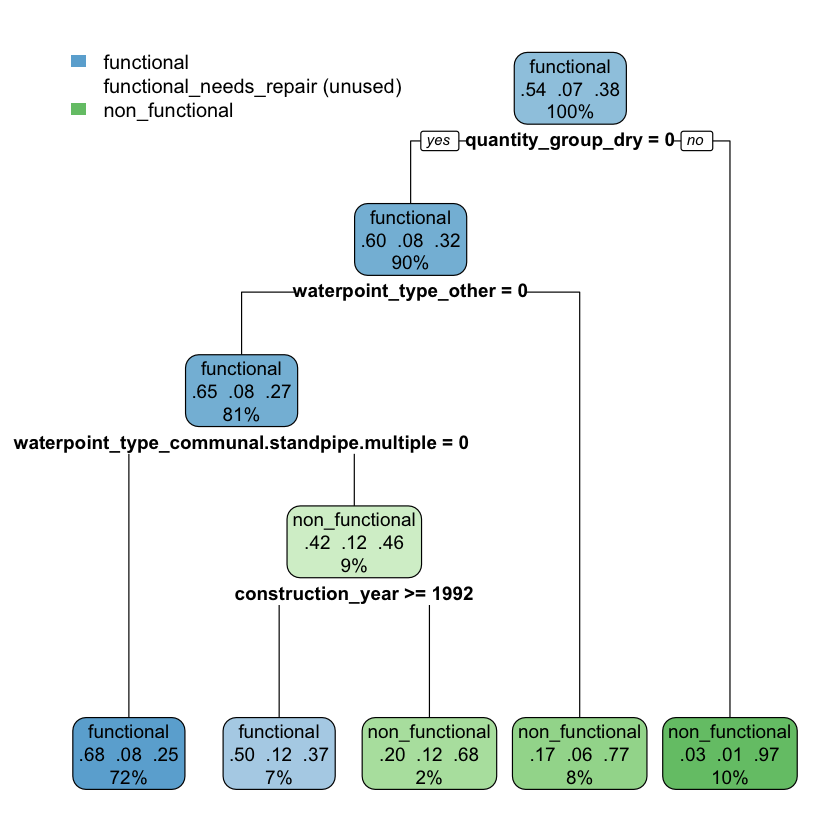

In [30]:
rpart.plot(tree)

## Model 2 - nnet

For the second model we decided to implement an Artificial Neural Network using the nnet library. This network is inspired by the structure of the nervous system. A set of neurons will be interconnected with each other to form a data-processing network. The weights which connects different layers and neurons will dynamically update during the training process in response to the input it receives. That dynamic allows the network to learn from past experiences.

Firstly, we will give the network the PCA encoding that was computed earlier, which will also be compared to the input without PCA reduction. 


Furthermore, the nnet function allows us to take the input labels as "one-hot" encoding. We will thus compare both methods, one taking a "one-hot" encoding a input labels and another taking the labels as before.

Note that the size of the hidden layer in our case was deemed reasonable at 5. Further tests with more hidden neurons were done but we couldn't say with certainty that one was definitaly better than the other. 

The following cell shows the implementation of the nnet model with PCA data as input.

In [31]:
###################################
###################################
#            DISCLAIMER: ~11 min
###################################
###################################


#nnet

#cross validation of nnet pca input

CV_folds <- 5

size_CV <-floor(N/CV_folds)




for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_final[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_final[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)

    # Model fit
    model<- nnet(status_group~.,data=DS, size=5, maxit=1000, MaxNWts=2000,trace=FALSE)#1000 max iterations ?

    # Model predict
    Y_hat_nnet<- predict(model,X_ts)
    Y_hat <- predict_transform(Y_hat_nnet)
    acc_nnet <- confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$overall['Accuracy']
    print(acc_nnet)
} 

 Accuracy 
0.7455387 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7380471 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7446128 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7393939 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7454545 


Let's look at what look like a typical neural network, now that we have an available network.

Loading required package: usethis

SHA-1 hash of file is bf3c7b8ac910823b729e3ce73bb6ab5e6955ad3d

Loading required package: scales

Loading required package: reshape


Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename




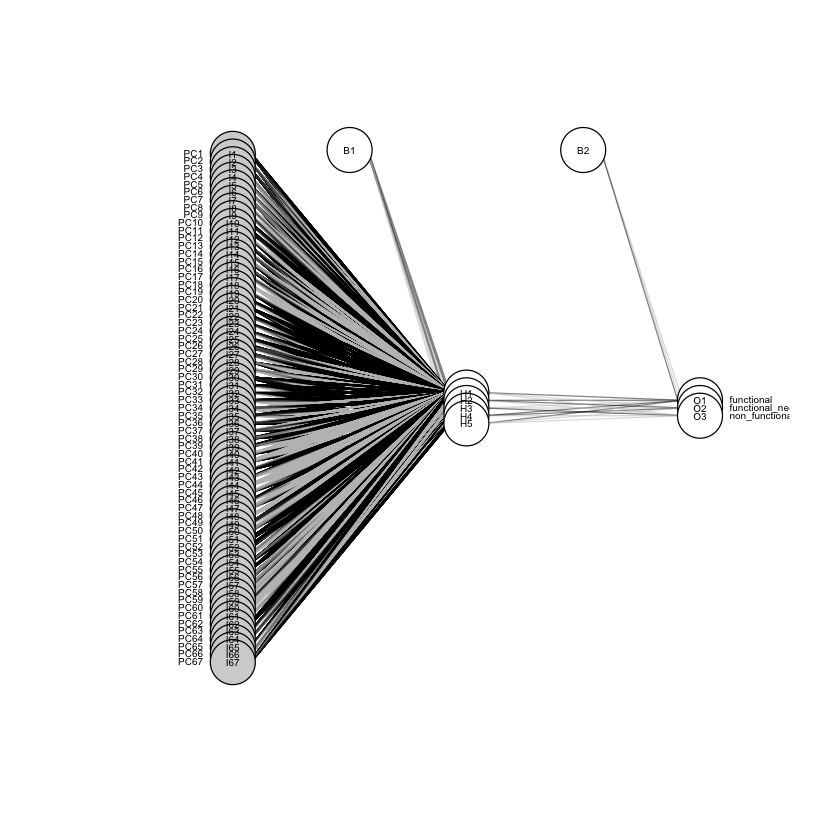

In [32]:
##########################
#DO NOT RUN THIS CELL IF PRECEDING CELL NOT RUN


library(devtools)
source_url('https://gist.githubusercontent.com/Peque/41a9e20d6687f2f3108d/raw/85e14f3a292e126f1454864427e3a189c2fe33f3/nnet_plot_update.r')
plot.nnet(model, alpha.val = 0.5, circle.col = list('lightgray', 'white'), bord.col = 'black', cex=0.5)

The following cell presents the 5-fold cross validation with the original dataset. We will thus compare both overall acuracies.

In [33]:
###################################
###################################
#            DISCLAIMER: ~8 min
###################################
###################################


#nnet

#cross validation of nnet non-pca

CV_folds <- 5

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=1,ncol=CV_folds)
threshold <- 0.5


for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_onehot[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_onehot[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)

    # Model fit (using lm function)
    model<- nnet(status_group~.,data=DS, size=5, maxit=1000, MaxNWts=2000,trace=FALSE)#1000 max iterations ?

    # Model predict
    Y_hat_nnet<- predict(model,X_ts)
    Y_hat <- predict_transform(Y_hat_nnet)
    acc_nnet <- confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$overall['Accuracy']
    print(acc_nnet)
} 

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7393939 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7372896 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7289562 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7156566 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7436027 


It can be seen that similar results are yielded from before. In this particular instance, we might think that we have slightly worst results, but accross multiple rounds, we concluded that this difference was not signifcant and thus both dataset are basically equivalent. 

Here is the cell taking labels with a one hot encoding. We will use the PCA dataset since we do not see any significant differences between one another.  

In [34]:
###################################
###################################
#            DISCLAIMER: ~8 min
###################################
###################################


#nnet one hot as input labels

CV_folds <- 5

size_CV <-floor(N/CV_folds)


for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_final[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_final[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)

    # Model fit (using lm function)
    model<- nnet(x=X_tr,y=class.ind(as.factor(Y_tr)), size=5, maxit=1000, MaxNWts=2000,trace=FALSE)#1000 max iterations ?

    # Model predict
    Y_hat_nnet<- predict(model,X_ts)
    Y_hat <- predict_transform(Y_hat_nnet)
    acc_nnet <- confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$overall['Accuracy']
    print(acc_nnet)
} 

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7470539 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7419192 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Accuracy 
 0.74133 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


 Accuracy 
0.7223906 


Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Accuracy 
0.737963 


In [35]:
##########################
#DO NOT RUN THIS CELL IF PRECEDING CELL NOT RUN

Y_hat_nnet<- predict(model,X_ts)
Y_hat <- predict_transform(Y_hat_nnet)
confusionMatrix(as.factor(Y_hat),as.factor(Y_ts))$table

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(Y_ts)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


                         Reference
Prediction                functional functional_needs_repair non_functional
  functional                    6120                     756           1922
  functional_needs_repair          0                       0              0
  non_functional                 351                      84           2647

Once again, the nnet doesn't predict the class 'functional_needs_repair' which would by definition limit the accuracy of the model and thus would not be optimal. Hopefully, the last model will perform better.

In conclusion, we can see that we do not particularly benefit from the PCA reduction since it doesn't really improve the computational time. Further more, the model training with the one-hot encoding as input labels perform equally tho others. We couldn't conclude that one input is better than an other

## Model 3 - Random Forest

The next model we'll evaluate is Breiman and Cutler's Random Forests for Classification and Regression, under the randomForest library. Random forest combines multiple decision trees which were trained individually on a different subset of samples and with different subset of randomly selected features. This random selection decorrelates the predictions of different trees. 


Firstly, we will estimate the number of trees yielding the best overall accuracy. We have to keep in mind that computational time is also a priority, so we'll decide the number of trees based on those two critierion. The next cell plots the accuracy per number of trees.

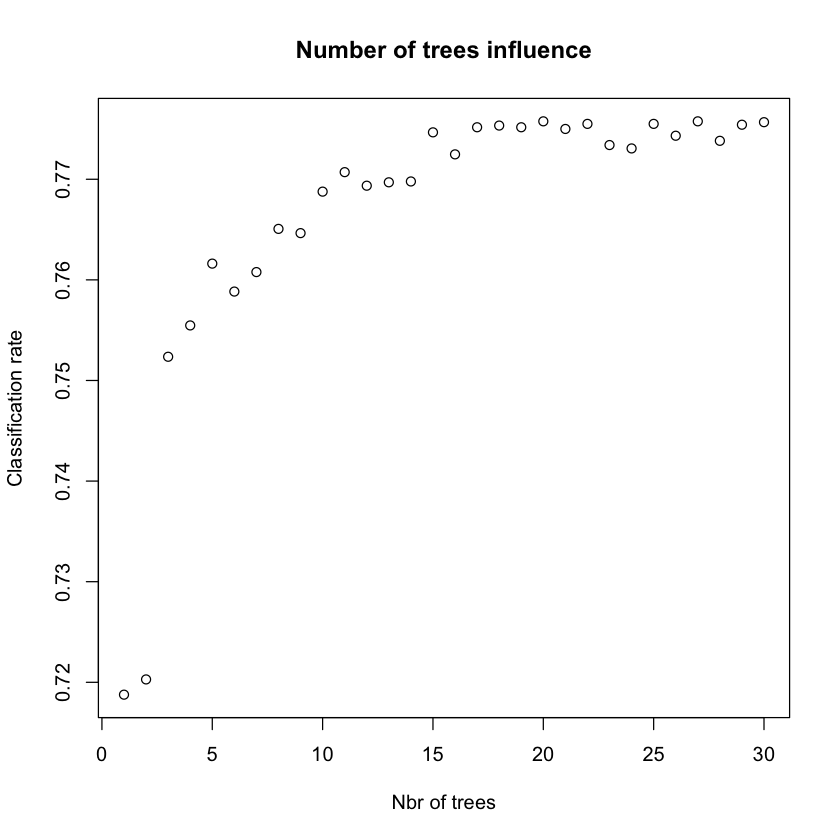

In [36]:
###################################
###################################
#            DISCLAIMER: ~7 min
###################################
###################################

n_trees <- 30

accuracy_vec <- array(0,n_trees)

idx_ts<-((3*size_CV+1):(4*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
X_ts<-X_final[idx_ts,]  
Y_ts<-Y[idx_ts,]


idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
X_tr<-X_final[idx_tr,]
Y_tr<-Y[idx_tr,]         
    # Create a dataset including only the first nb_components principal components
DS<-cbind(X_tr,status_group=Y_tr)
DS$status_group<-factor(DS$status_group)

for (i in 1:n_trees){
    
    nb_trees <- randomForest(status_group~.,data=DS,
                          ntree=i)
    
    Y_hat_rf<- predict(nb_trees,X_ts)
    acc_forest <- confusionMatrix(as.factor(Y_hat_rf),as.factor(Y_ts))$overall['Accuracy']
    accuracy_vec[i] = acc_forest
    }

plot(accuracy_vec,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate")

Looking at the global shape of the curve, it seems that a good number of trees could be around 15. That way we are close enough to the best accuray while gaining potentially a lot in computational time. 

The next cell applies the 5-fold cross validation on our randomForest, as input our PCA dataset. Note that the randomForest funciton returns labels, and not a "one-hot" probability encoding like the two preceding models, o the function predic_transform is not necessary in that case.

In [98]:
###################################
###################################
#            DISCLAIMER: ~11 min
###################################
###################################


#cross validation of random forest pca input

CV_folds <- 5

size_CV <-floor(N/CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_final[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_final[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)
                     
    #randomForest
    forest<- randomForest(status_group~.,data=DS, ntrees=15)

    # Model predict
    Y_hat_rf<- predict(forest,X_ts)
    acc_forest <- confusionMatrix(as.factor(Y_hat_rf),as.factor(Y_ts))$overall['Accuracy']
    print(acc_forest)
} 

 Accuracy 
0.7823232 
 Accuracy 
0.7799663 
 Accuracy 
0.7830808 
 Accuracy 
0.7806397 
 Accuracy 
0.7822391 


In [37]:
###################################
###################################
#            DISCLAIMER: ~24 min
###################################
###################################


#cross validation of random forest with original dataset

CV_folds <- 5

size_CV <-floor(N/CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_onehot[idx_ts,]  
    Y_ts<-Y[idx_ts,]
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_onehot[idx_tr,]
    Y_tr<-Y[idx_tr,]         
        # Create a dataset including only the first nb_components principal components
    DS<-cbind(X_tr,status_group=Y_tr)
    DS$status_group<-factor(DS$status_group)
                     
    #randomForest
    forest<- randomForest(status_group~.,data=DS, ntrees=15)

    # Model predict
    Y_hat_rf<- predict(forest,X_ts)
    acc_forest <- confusionMatrix(as.factor(Y_hat_rf),as.factor(Y_ts))$overall['Accuracy']
    print(acc_forest)
} 

 Accuracy 
0.8005892 
 Accuracy 
0.7954545 
 Accuracy 
0.7987374 
 Accuracy 
0.7926768 
 Accuracy 
0.7975589 


Comparing the 2 training procedures, we can see a 1.5% improvement in accuracy when giving the original dataset rather than the PCA reduced one. But this improvement comes with a computational cost, and a rather big one. The training time taken is more than twice the time taken for the model taking PCA as input. If the accuracy is an absolute priotrity, then training with the original dataset is preferable.

# Alternative models

## XGBoost



As an alternative model, we decided to use a XGBoost model as it is a very popular model in Machine
Learning. XGBoost stands for Extreme Gradient Boosting and is a tree based ensemble machine learning algorithm. Its main advantages are that the execution speed is better than other boosting algorithms and its performance are great.
It requires to encode the classes in our label set starting from 0, which is what we do below.

In [44]:
# XGBoost requires the classes to be in integer format, starting with 0.
set_labels$status_group[set_labels$status_group == 'functional']<-0
set_labels$status_group[set_labels$status_group == 'functional needs repair']<-1
set_labels$status_group[set_labels$status_group == 'non functional']<-2
set_labels$status_group<-factor(set_labels$status_group)

num_class = length(levels(set_labels$status_group))
states = set_labels$status_group

label = as.integer(states)-1

We split the dataset in a training (75%) and testing (25%) set. We apply it on the datasets where we used PCA and the other without PCA to see the impact of the preprocessing phase.

In [45]:
# data set is split for training (75%) and testing (25%)
n = nrow(X_final)

# training data set is used to fit the model
train.index = sample(n,floor(0.75*n))
train.data = as.matrix(X_final[train.index,])
head(train.data)
train.label = label[train.index]
head(train.label)
#  testing data set is held out for validation
test.data = as.matrix(X_final[-train.index,])
test.label = label[-train.index]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67
1709,1.946224,-2.0255811,-5.1571751,-1.01084927,-1.0778916,-1.67306763,-2.7151621,0.03048211,-3.2678669,0.7968864,⋯,-0.47971439,1.03559848,-1.62867042,0.5317010,-1.54314343,-1.21112347,0.39344705,-0.2555068,-0.1236431,-0.9798515
50188,2.598294,0.4353866,-9.9613081,1.66921432,-0.9495155,6.43426392,1.9678903,1.68166760,5.0588000,0.7485742,⋯,0.17548172,-0.03007113,-0.02794110,0.1433873,-0.05891811,-0.18820962,-0.09130097,0.6556927,1.2260725,0.3292472
54233,-2.882801,2.3359242,0.8291524,-2.55023045,1.2493336,-1.17731491,0.5101361,0.26908088,0.7414213,-1.1334254,⋯,-0.09719375,-0.07759184,-0.12053855,0.5436816,-0.89126413,0.76608538,0.28027438,-0.8505393,1.2077240,0.4174433
50878,-1.070107,-4.7725262,2.8640075,0.03106349,0.5891541,5.70599053,-2.9674096,1.33067731,-1.3059530,-3.6801855,⋯,0.97977865,0.11665932,-0.19320279,0.1616962,0.34782810,-0.02751999,-1.53013884,-0.7295312,1.0001748,-1.0587042
15308,2.320043,0.2082470,3.0685964,1.55733376,0.2857620,0.01762214,1.7022680,1.33541404,1.4684207,-0.6003030,⋯,-0.71130098,0.11940781,0.07838428,0.3550993,-0.02141224,0.43775093,0.93471821,0.4765754,-0.5600379,-1.0518840
34977,4.622356,-0.3735790,-0.9020669,-0.34995715,-7.0285446,-2.73375379,0.1206752,-0.44911914,-0.2549334,-2.3386766,⋯,0.24036320,0.17271665,-0.13650546,-0.1702353,0.78252282,-0.05315457,-0.56840463,0.1562910,-0.3539390,0.2408247


[1] 0 1 0 2 2 0

In [46]:
# data set is split for training (75%) and testing (25%)
n = nrow(X_final)

# training data set is used to fit the model
train_nopca.index = sample(n,floor(0.75*n))
train_nopca.data = as.matrix(X_onehot[train_nopca.index,])
head(train_nopca.data)
train_nopca.label = label[train_nopca.index]
head(train_nopca.label)
#  testing data set is held out for validation
test_nopca.data = as.matrix(X_onehot[-train_nopca.index,])
test_nopca.label = label[-train_nopca.index]
head(test_nopca.label)

,amount_tsh,gps_height,longitude,latitude,basin_Internal,basin_Lake.Nyasa,basin_Lake.Rukwa,basin_Lake.Tanganyika,basin_Lake.Victoria,basin_Pangani,⋯,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle.trough,waterpoint_type_communal.standpipe,waterpoint_type_communal.standpipe.multiple,waterpoint_type_dam,waterpoint_type_hand.pump,waterpoint_type_improved.spring,waterpoint_type_other
21834,0,0,33.54535,-9.162204,0,1,0,0,0,0,⋯,1,0,0,0,1,0,0,0,0,0
18898,0,0,31.74125,-1.613649,0,0,0,0,1,0,⋯,1,0,0,0,0,0,0,0,1,0
21428,0,1302,30.84889,-3.411914,0,0,0,1,0,0,⋯,1,0,0,0,0,0,0,0,1,0
30670,0,0,32.31199,-4.705580,0,0,0,1,0,0,⋯,1,0,0,0,0,0,0,1,0,0
55884,500,304,36.99287,-7.602332,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,1,0,0
27543,0,1306,30.85245,-3.272095,0,0,0,1,0,0,⋯,1,0,0,0,0,0,0,1,0,0


[1] 0 0 0 2 0 2

[1] 0 0 2 2 1 1

In [47]:
# DMatrix objects that are used for fitting the XGBoost model and predicting new outcomes
xgb.train = xgb.DMatrix(data=train.data,label=train.label)
xgb.test = xgb.DMatrix(data=test.data,label=test.label)

In [48]:
xgb_nopca.train = xgb.DMatrix(data=train_nopca.data,label=train_nopca.label)
xgb_nopca.test = xgb.DMatrix(data=test_nopca.data,label=test_nopca.label)

XGBoost works best when its parameters are hypertuned for optimal performance.
Here, found the parameters to be optimal through simple tests, changing one parameter at a time. The parameter eta is the step size of each boosting step. The max.depth is the maximum depth of the tree. Gamma is the minimum loss reduction required to make a further partition on a leaf node of the tree.
The objective parameter multi:softprob tells the algorithm to calculate probabilities for every possible outcome
(in this case, a probability for each of the three states of water pumps), for every observation.
The parameter eval_metric mlogloss tells the XGBoost algorithm that we want to use a multiclass logloss as our evaluation metric.


In [49]:
# Define the parameters for multinomial classification
num_class = length(levels(states))
params = list(
  booster="gbtree",
  eta=0.3,
  max_depth=8,
  gamma=0,
  subsample=0.75,
  colsample_bytree=1,
  objective="multi:softprob",
  eval_metric="mlogloss",
  num_class=num_class
)

We use the cross validation to asses the error rate because if we rely on one simple training and validation set, the results can be vastly different depending on the split of the data chosen.

In [52]:
###################################
###################################
#            DISCLAIMER: ~8 min
###################################
###################################


#PCA input

cv.nfold  <- 5 # cv.nfold value here is arbitrary chosen. The number of cv.nfold will typically be 5 or 10


cv_model <- xgb.cv(params = params,
                   data = xgb.train,
                   nrounds = 100,
                   nfold = cv.nfold,
                   verbose = FALSE,
                   nthread=1,
                   early_stopping_rounds=30,
                   prediction = TRUE)



In [53]:
###################################
###################################
#            DISCLAIMER: ~8 min
###################################
###################################

#No PCA

cv_nopca_model <- xgb.cv(params = params,
                   data = xgb_nopca.train,
                   nrounds = 100,
                   nfold = cv.nfold,
                   verbose = FALSE,
                   nthread=1,
                   early_stopping_rounds=30,
                   prediction = TRUE)

The pred object contains the predicted value for each observation in our train dataset
To test the prediction, we need to assign a class, which is why we use max.col() to assign the class that has the highest probability. 

In [54]:
##########################
#DO NOT RUN THIS CELL IF PRECEDING CELL NOT RUN


# the probability that each observation belongs to each class
OOF_prediction <- data.frame(cv_model$pred) %>%
  mutate(max_prob = max.col(., ties.method = "last"),
         label = train.label + 1)
head(OOF_prediction)

OOF_prediction_nopca <- data.frame(cv_nopca_model$pred) %>%
  mutate(max_prob = max.col(., ties.method = "last"),
         label = train_nopca.label + 1)
head(OOF_prediction_nopca)

,X1,X2,X3,max_prob,label
,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0.499856204,0.029237108,0.4709067,1,1
2,0.394733578,0.561270535,0.0439959,2,2
3,0.889872551,0.035945401,0.0741820,1,1
4,0.017967209,0.003313795,0.9787189,3,3
5,0.007926054,0.013515540,0.9785584,3,3
6,0.095878795,0.018150967,0.8859702,3,1


,X1,X2,X3,max_prob,label
,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0.8722660,0.075246304,0.052487757,1,1
2,0.7323121,0.134695739,0.132992193,1,1
3,0.9794514,0.012646510,0.007902117,1,1
4,0.6127661,0.009393054,0.377840877,1,3
5,0.9452881,0.001636519,0.053075459,1,1
6,0.1361590,0.002174134,0.861666858,3,3


The confusion matrix  assess the error rate.

In [55]:
##########################
#DO NOT RUN THIS CELL IF PRECEDING CELL NOT RUN


# confusion matrix
confusionMatrix(factor(OOF_prediction$max_prob),
                factor(OOF_prediction$label),
                mode = "everything")$table

confusionMatrix(factor(OOF_prediction$max_prob),
                factor(OOF_prediction$label),
                mode = "everything")$overall['Accuracy']

confusionMatrix(factor(OOF_prediction_nopca$max_prob),
                factor(OOF_prediction_nopca$label),
                mode = "everything")$table

confusionMatrix(factor(OOF_prediction_nopca$max_prob),
                factor(OOF_prediction_nopca$label),
                mode = "everything")$overall['Accuracy']

          Reference
Prediction     1     2     3
         1 21513  1879  4393
         2   435   767   191
         3  2303   547 12522

Accuracy 
0.7811897

          Reference
Prediction     1     2     3
         1 21836  1812  3949
         2   437   918   203
         3  1973   497 12925

Accuracy 
0.8008754

In conclusion, there is almost a 2% benefit from keeping our databes intact rather than doing the PCA reduction. In addition, we do not see any particular improvement in training time using the PCA reduction overall. Thus, in the following, only the original dataset will be used to test and train the models. Furthermore, looking at the results so far, XGBoost is the best performing model overall. Let's try one last model which will combine models.

## Combination of models

In this part, we will test whether or not combining the individual predictions can improve the performance. To that end, we will take the 3 best performing models (i.e. nnet, randomForest and XGBoost) and make a final prediction based on those tree. For a given input, the class predicted most will be selected as the final prediction, if there's equality, the best performing model determines the final prediction. First let's reuse the same function from before because we will need it. This is placed here in case the evaluation is done between multiple sessions.

In [47]:
threshold <- 0.5

predict_transform <- function(Y_hat_tree){
    Y_hat <- t(apply(Y_hat_tree, 1, function(x)(x-min(x))/(max(x)-min(x))))
                 
    Y_hat[,1] <- ifelse(Y_hat[,1] < 0.99,0,1)
    Y_hat[,2] <- ifelse(Y_hat[,2] < 0.99,0,1)
    Y_hat[,3] <- ifelse(Y_hat[,3] < 0.99,0,1)
    Y_hat <- ifelse(Y_hat[,1] > threshold,"functional",ifelse(Y_hat[,2] > threshold,"functional_needs_repair","non_functional"))
    return(Y_hat)
}

Let's start by selecting a dataset over which we will train each models individually. We split the data into 75% training set and 25% testing set. The next cell does exactly that. Note that we are using the original database not PCA reduced because we concluded that overall, we do not gain very much in computational time.

In [38]:
# data set is split for training (75%) and testing (25%)
n = nrow(X_onehot)

# training data set is used to fit the model

train.index = sample(n,floor(0.75*n))# random picking so might make accuracies change moving forward, keep in mind
#cf pdf for exact accuracies


train.data = X_onehot[train.index,]
train_xg.data = as.matrix(X_onehot[train.index,])
head(train.data)
train.label = Y[train.index,]
head(train.label)

train_xg.label = label[train.index]
head(train_xg.label)
#  testing data set is held out for validation
test.data = X_onehot[-train.index,]
test_xg.data = as.matrix(X_onehot[-train.index,])
test.label = Y[-train.index,]
head(test.label)
test_xg.label = label[-train.index]
head(test_xg.label)

,amount_tsh,gps_height,longitude,latitude,basin_Internal,basin_Lake.Nyasa,basin_Lake.Rukwa,basin_Lake.Tanganyika,basin_Lake.Victoria,basin_Pangani,⋯,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle.trough,waterpoint_type_communal.standpipe,waterpoint_type_communal.standpipe.multiple,waterpoint_type_dam,waterpoint_type_hand.pump,waterpoint_type_improved.spring,waterpoint_type_other
,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
12713,2500,1289,38.37597,-4.821845,0,0,0,0,0,1,⋯,1,0,0,0,1,0,0,0,0,0
13700,0,1669,34.87898,-4.895629,1,0,0,0,0,0,⋯,1,0,0,0,1,0,0,0,0,0
32592,0,472,37.04953,-6.829116,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,1,0,0
21257,0,22,39.16508,-8.515174,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,1,0,0
54542,0,1596,34.73568,-1.887667,0,0,0,0,1,0,⋯,1,0,0,0,0,0,0,1,0,0
54501,0,0,33.28647,-2.644896,0,0,0,0,1,0,⋯,1,0,0,0,0,0,0,0,0,1


[1] "non_functional" "non_functional" "functional"     "non_functional"
[5] "functional"     "non_functional"

[1] 2 2 0 2 0 2

[1] "functional" "functional" "functional" "functional" "functional"
[6] "functional"

[1] 0 0 0 0 0 0

This cell will create the data stricly for the xg model.

In [39]:
# transform the training and testing data sets into xgb
# DMatrix objects that are used for fitting the XGBoost model and predicting new outcomes
xgb.train = xgb.DMatrix(data=train_xg.data,label=train_xg.label)
xgb.test = xgb.DMatrix(data=test_xg.data,label=test_xg.label)

This cell will create the input data for the two other models.

In [40]:
#randomForest
DS<-cbind(train.data,status_group=train.label)
DS$status_group<-factor(DS$status_group)

The following cell trains the randomForest on the data and evaluate it in the testing data.

In [41]:
###################################
###################################
#            DISCLAIMER: ~4.5 min
###################################
###################################


forest<- randomForest(status_group~.,data=DS, ntrees=15)
Y_hat_rf<- predict(forest,test.data)
confusionMatrix(as.factor(Y_hat_rf),as.factor(test.label))$overall['Accuracy']

Accuracy 
0.7963636

In [42]:
#saveRDS(forest, "tree.rds")

In [61]:
#Model used for combined model accuracy
forest <- readRDS("tree.rds")
Y_pred<-predict(forest,test.data)
confusionMatrix(as.factor(Y_pred),as.factor(test.label))$overall['Accuracy']
confusionMatrix(as.factor(Y_pred),as.factor(test.label))$table

Accuracy 
0.796431

                         Reference
Prediction                functional functional_needs_repair non_functional
  functional                    7496                     703           1501
  functional_needs_repair         92                     213             48
  non_functional                 523                     156           4118

The following cell trains the nnet on the data and evaluate it in the testing data.

In [44]:
#nnet ~2 min
net<- nnet(status_group~.,data=DS, size=5, maxit=1000, MaxNWts=2000,trace=FALSE)

In [63]:
Y_hat_nnet<- predict(net,test.data)
Y_hat <- predict_transform(Y_hat_nnet)
confusionMatrix(as.factor(Y_hat),as.factor(test.label))$overall['Accuracy']

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(test.label)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Accuracy 
0.7389899

In [49]:
#saveRDS(net, "nnet.rds")

In [62]:
#Model used for combined model accuracy
net <- readRDS("nnet.rds")
Y_hat_nnet<- predict(net,test.data)
Y_hat <- predict_transform(Y_hat_nnet)
confusionMatrix(as.factor(Y_hat),as.factor(test.label))$overall['Accuracy']
confusionMatrix(as.factor(Y_hat),as.factor(test.label))$table

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(test.label)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Accuracy 
0.7389899

Warning message in levels(reference) != levels(data):
“la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court”
Warning message in confusionMatrix.default(as.factor(Y_hat), as.factor(test.label)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


                         Reference
Prediction                functional functional_needs_repair non_functional
  functional                    7396                     890           2089
  functional_needs_repair          0                       0              0
  non_functional                 715                     182           3578

In [52]:
###################################
###################################
#            DISCLAIMER: ~18.5 min
###################################
###################################


#XGBoost

bst_model <- xgb.train(params = params,
                       data = xgb.train,
                       nrounds = 350)

In [56]:
##########################
#DO NOT RUN THIS CELL IF PRECEDING CELL NOT RUN


test_pred <- predict(bst_model, newdata = xgb.test)
test_prediction <- matrix(test_pred, nrow = num_class,
                          ncol=length(test_pred)/num_class) %>%
  t() %>%
  data.frame() %>%
  mutate(label = test_xg.label + 1,
         max_prob = max.col(., "last"))
# confusion matrix of test set
confusionMatrix(factor(test_prediction$max_prob),
                factor(test_prediction$label),
                mode = "everything")$overall['Accuracy']
confusionMatrix(factor(test_prediction$max_prob),
                factor(test_prediction$label),
                mode = "everything")$table

Accuracy 
0.8039731

          Reference
Prediction    1    2    3
         1 7161  551 1139
         2  205  344   94
         3  745  177 4434

In [57]:
#saveRDS(bst_model, "xg.rds")

In [59]:
#Model used for combined model AND final prediction for driven data

bst_model <- readRDS("xg.rds")
Y_pred<-predict(bst_model,test_xg.data)
Y_pred <- matrix(Y_pred, nrow = num_class,
                          ncol=length(Y_pred)/num_class)%>%
  t() %>%
  data.frame()

In [ ]:
test_pred <- predict(bst_model, newdata = xgb.test)
test_prediction <- matrix(test_pred, nrow = num_class,
                          ncol=length(test_pred)/num_class) %>%
  t() %>%
  data.frame() %>%
  mutate(label = test_xg.label + 1,
         max_prob = max.col(., "last"))
# confusion matrix of test set
confusionMatrix(factor(test_prediction$max_prob),
                factor(test_prediction$label),
                mode = "everything")$overall['Accuracy']
confusionMatrix(factor(test_prediction$max_prob),
                factor(test_prediction$label),
                mode = "everything")$table

Now that the models are all trained on the same data, it is time to construct the combined model. Firstly, since some models (nnet and XGBoost) returns a prediction of 3 columns and a probability over each classes, we create a function which only returns a 1 in the maximum class and zeroes and the others.

In [65]:
ones <- function(Y){
    Y_hat <- t(apply(Y, 1, function(x)(x-min(x))/(max(x)-min(x))))
                 
    Y_hat[,1] <- ifelse(Y_hat[,1] < 0.99,0,1)
    Y_hat[,2] <- ifelse(Y_hat[,2] < 0.99,0,1)
    Y_hat[,3] <- ifelse(Y_hat[,3] < 0.99,0,1)
                     
    return(Y_hat)
}

The evaluation is the following, we will add the individual predictions into a final frame. The column with the best score will be the final prediction. If there is an equality (i.e. all models predict a different class), the model with the best accuracy will determine the final prediction, which is this case .

In [73]:
combined_models <- function(X_ts){
    
    X_xg_ts = as.matrix(X_ts)#transformation for xgb
    
    # predictions
    Y_pred_forest<-predict(forest,X_ts)
    Y_pred_forest <- do.call(rbind, lapply(Y_pred_forest, function(i) as.integer(!is.na(match(unique(unlist(Y_pred_forest)), i)))))
    
    
    Y_pred_nnet<-predict(net,X_ts)
    
    
    Y_pred_xg<-predict(bst_model,X_xg_ts)
    Y_pred_xg <- matrix(Y_pred_xg, nrow = num_class,
                          ncol=length(Y_pred_xg)/num_class)%>%
      t() %>%
      data.frame()
          
                                           
    # computing the final prediction
    final <- ones(Y_pred_nnet)+ones(Y_pred_xg)+Y_pred_forest
                                           

                                           
    for (i in 1:(length(final)/num_class)){
        n<-final[i,]
        if ((n[1]==n[2]) & (n[2]==n[3]) & (n[1]==n[3])){
            final[i,]<-ones(Y_pred_xg)[i,]
        }
    }
    final <- predict_transform(final)#transforming into labels
    return(final)
    
}

In [74]:
#Evaluation of the combined models

Y_pred <- combined_models(test.data)
confusionMatrix(factor(Y_pred),
                factor(test.label),
                mode = "everything")$table
confusionMatrix(factor(Y_pred),
                factor(test.label),
                mode = "everything")$overall['Accuracy']

                         Reference
Prediction                functional functional_needs_repair non_functional
  functional                    7611                     718           1574
  functional_needs_repair         91                     192             50
  non_functional                 409                     162           4043

Accuracy 
0.7977104

Unfortunately, this combined model does not partically improve the accuracy overall. So for the final submission we will rather use the XGBoost model.

# Submission

In this section is detailed the steps recreating our previous work to try and predict the testing set given. To that end, let's load the correct testing set and recreate the feature selection and engineering from the first section. The next two cells starts this procedure. 

In [39]:
set_val_test <- read.csv("database/Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv", header=TRUE)
head(set_val_test)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,⋯,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,50785,0,2013-02-04,Dmdd,1996,DMDD,35.29080,-4.059696,Dinamu Secondary School,0,⋯,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
2,51630,0,2013-02-04,Government Of Tanzania,1569,DWE,36.65671,-3.309214,Kimnyak,0,⋯,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
3,17168,0,2013-02-01,,1567,,34.76786,-5.004344,Puma Secondary,0,⋯,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
4,45559,0,2013-01-22,Finn Water,267,FINN WATER,38.05805,-9.418672,Kwa Mzee Pange,0,⋯,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
5,49871,500,2013-03-27,Bruder,1260,BRUDER,35.00612,-10.950412,Kwa Mzee Turuka,0,⋯,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
6,52449,0,2013-03-04,Government Of Tanzania,1685,DWE,36.68528,-3.302420,Masaga,0,⋯,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [40]:
library(tibble)

# Delete the columns in cleaning based on the redundancy, the relevance of the information, etc.
cleaning <- c("id","date_recorded", "num_private", "funder", "installer", "wpt_name", "subvillage", "lga", "ward", 
              "region_code", "scheme_name", "payment", "quantity", "waterpoint_type_group", "recorded_by", "district_code")
X<-set_val_test[,setdiff(colnames(set_val_test),cleaning)]


#On some distributions NA are represented with empty string so we first set them to NA 
#to use is.na effectively
X<-replace(X,X=='',NA)#Replaced to NA

#Replacing NA values in categorical features with the most frequent occurence
X$permit[is.na(X$permit)] <- tail(names(sort(table(X$permit))), 1)

X$scheme_management[is.na(X$scheme_management)] <- tail(names(sort(table(X$scheme_management))), 1)

X$public_meeting[is.na(X$public_meeting)] <- tail(names(sort(table(X$public_meeting))), 1)

#For numericals, replace by the median

X$construction_year[X$construction_year==0] <- NA
X$construction_year[is.na(X$construction_year)] <- median(X$construction_year,na.rm=T)
X$construction_year <- as.integer(X$construction_year)


#Same for longitude and latitude
#Since zero isn't in the range of longitudes of Tanzania
X$longitude[X$longitude==0] <- NA
X$longitude[is.na(X$longitude)] <- median(X$longitude,na.rm=T)

X$latitude[X$latitude==-0.00000002] <- NA
X$latitude[is.na(X$latitude)] <- median(X$latitude,na.rm=T)


#For permit, the categorical values are bolleans true-false so we can encode them on only one column with 0 and 1, same goes
#for public meeting
X$permit[X$permit=='True'] <- 1
X$permit[X$permit=='False'] <- 0
X$permit <- as.integer(X$permit)

X$public_meeting[X$public_meeting=='True'] <- 1
X$public_meeting[X$public_meeting=='False'] <- 0
X$public_meeting <- as.integer(X$public_meeting)



#One hot encoding
library(dummies)


variables_to_keep<-names(X)
X_onehot_2 <- dummy.data.frame(X[,variables_to_keep], sep="_")

names(X_onehot_2)<-make.names(names(X_onehot_2))#required to have concatenated names in order for randomForest to run

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts ar

Beware, the 'one-hot' encoding leaves this dataset without 2 features since those labels were not present originally. Thus, let's add 2 columns at the right position.

In [41]:
setdiff(names(X_onehot),names(X_onehot_2))

[1] "scheme_management_None"                   
[2] "extraction_type_other...mkulima.shinyanga"

In [42]:
which(names(X_onehot)=="scheme_management_None")
which(names(X_onehot)=="extraction_type_other...mkulima.shinyanga")

[1] 38

[1] 61

In [43]:
X_onehot_2<-add_column(X_onehot_2, scheme_management_None = 0, .after = 37)
X_onehot_2<-add_column(X_onehot_2, extraction_type_other...mkulima.shinyanga = 0, .after = 60)

X_onehot_2$scheme_management_None <- as.integer(X_onehot_2$scheme_management_None)
X_onehot_2$extraction_type_other...mkulima.shinyanga <- as.integer(X_onehot_2$extraction_type_other...mkulima.shinyanga)


test_xg.data = as.matrix(X_onehot_2)
xgb.test = xgb.DMatrix(data=test_xg.data)

Now that the testing set is correctly formed, we can predict the output using the best model. To that end, we will predict using the XGBoost model since it had the best overall accuracy. In addition, contrary to a model like nnet, it indeed predicted the class 'functional_needs_repair'. 

In [93]:
bst_model <- readRDS("xg.rds")

test_pred <- predict(bst_model, newdata = xgb.test)
test_prediction <- matrix(test_pred, nrow = num_class,
                          ncol=length(test_pred)/num_class) %>%
  t() %>%
  data.frame()

In [94]:
test_prediction <- predict_transform(test_prediction)

In [95]:
head(data.frame(test_prediction))

,test_prediction
,<chr>
1,functional
2,functional
3,functional
4,non_functional
5,functional
6,functional


We can finally introduce our results into the sub_format, and then save the results into a file. Before that, we need to make sure the labels are correct since we did a transform to eliminate the spaces. Thus reintroducing the right orthograph is done also.

In [85]:
sub_format[,2] <- test_prediction
head(sub_format)

,id,status_group
,<int>,<chr>
1,50785,functional
2,51630,functional
3,17168,functional
4,45559,non_functional
5,49871,functional
6,52449,functional


In [86]:
sub_format[sub_format == "functional_needs_repair"] <- "functional needs repair"
sub_format[sub_format == "non_functional"] <- "non functional"

head(sub_format)

,id,status_group
,<int>,<chr>
1,50785,functional
2,51630,functional
3,17168,functional
4,45559,non functional
5,49871,functional
6,52449,functional


In [87]:
#write.csv(sub_format,"sub.csv" ,row.names = FALSE) #commented since the final file is in the folder

# Conclusions


In conclusion, this project gave use the opportunity to test different models and methods head to head. We concluded that the XGBoost is the best performing overall, even when combining multiple models. Furthermore, PCA did not particularly reduce the computational time when training while ever so slightly reducing the overall performance, so we decided to exclude it in our final prediction. 


Finally, we can conclude that a basic XGBoost can yield good results since it gave us a final evaluation of 81% on Driven-Data evaluation.

# Sources

https://en.wikipedia.org/wiki/Recursive_partitioning

https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/#:~:text=XGBoost%20is%20an%20algorithm%20that,designed%20for%20speed%20and%20performance.

https://rstudio-pubs-static.s3.amazonaws.com/456044_9c275b0718a64e6286751bb7c60ae42a.html

https://rstudio-pubs-static.s3.amazonaws.com/233321_06bcdf2c8bc445dbb635740bb44f978b.html

INFOF422 - Course of Statistical foundations of Machine Learning

https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/

https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788397872/1/ch01lvl1sec27/pros-and-cons-of-neural-networks

https://cran.r-project.org/web/packages/rpart/vignettes/longintro.pdf